In [1]:
import csv
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from PIL import Image
import pickle
import math

In [20]:
train_orig = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train_orig.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [21]:
print(len(train_orig['Image'][1].split(' ')))
# convert img col into 96*96 array
def reshape_image(image):
    image = image.split(' ')
    img_to_int = np.vectorize(int)
    image = img_to_int(image)
    return np.reshape(image, (96,96))

train_orig['Image'] = train_orig['Image'].apply(reshape_image)
test['Image'] = test['Image'].apply(reshape_image)

9216


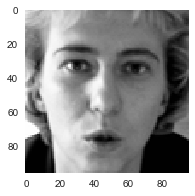

In [5]:
im = Image.fromarray(train_orig['Image'][1], mode='I')
plt.figure(figsize=(3,3))
plt.imshow(im)
plt.grid(False)

In [6]:
#num missing for each col
# train.isnull().sum()

#split into train and validation
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train_orig, test_size=0.2, random_state=888)

# find mean of each keypoint's coords across train set
keypoint_coord_means_train = round(train.iloc[:, 0:30].mean(axis=0, skipna=True))

In [7]:
# using mean as prediction
# pd.DataFrame(keypoint_coord_means_train.values.reshape((1,30)), columns=keypoint_coord_means_train.index)
y_true = pd.Series()
y_pred = pd.Series()
for colname in validation.columns[0:30]:
    colname_y_true = validation.loc[~pd.isnull(validation[colname]), colname]
    y_true = y_true.append(colname_y_true)
    colname_y_pred = keypoint_coord_means_train[colname].repeat(len(colname_y_true))
    y_pred = y_pred.append(pd.Series(colname_y_pred))
    
# validation set pred error
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_true, y_pred))

3.8765174652537375

In [8]:
keypoints = ['left_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'mouth_center_bottom_lip',
 'mouth_center_top_lip',
 'mouth_left_corner',
 'mouth_right_corner',
 'nose_tip',
 'right_eye_center',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end']

keypoints_expanded = []
for keypoint in keypoints:
    keypoints_expanded.extend([keypoint + '_x', keypoint + '_y'])

In [9]:
# get all keypoint patches of all images
patch_size = 10
IMG_SIZE = len(train['Image'][0])

# find patches for given keypoints. If invalid patch, return np.nan
def find_patches_all_keypoints(row, keypoints, patch_size):
    patches = pd.Series(index=keypoints, dtype=object)
    for keypoint in keypoints:
        patches[keypoint] = find_patch_single_keypoint(row, keypoint, patch_size)
    return patches

def find_patch_single_keypoint(row, keypoint, patch_size):
    is_valid_patch, patch_boundary_coords = find_patch_boundary_coords(row, keypoint, patch_size)
    if is_valid_patch:
        x_left, x_right, y_top, y_bottom = patch_boundary_coords
        return row['Image'][y_top:y_bottom+1 , x_left:x_right+1]
    else:
        return np.nan

def find_patch_boundary_coords(row, keypoint, patch_size):
    center_x_coord = row[keypoint + '_x']
    center_y_coord = row[keypoint + '_y']

    # check that coords exist
    if np.isnan(center_x_coord) or np.isnan(center_y_coord):
        return False, (np.nan, np.nan, np.nan, np.nan)
    
    # get coords of 4 corners (inclusive)
    x_left = round(center_x_coord - patch_size)
    x_right = round(center_x_coord + patch_size)
    y_top = round(center_y_coord - patch_size)
    y_bottom = round(center_y_coord + patch_size)
    # check that patch is valid (coords within boundaries of image)
    if x_left>=0 and y_top>=0 and x_right<IMG_SIZE and y_bottom<IMG_SIZE:
        return True, (x_left, x_right, y_top, y_bottom)
    else:
        return False, (np.nan, np.nan, np.nan, np.nan)

In [10]:
# find means of all keypoints' patch
def find_all_keypoints_patches_means(df, keypoints, patch_size):
    all_keypoints_patches = df.apply(find_patches_all_keypoints, keypoints=keypoints, patch_size=10, axis=1)
    keypoint_patch_means = {}
    for keypoint in keypoints:
        keypoint_patch_means[keypoint] = np.mean(all_keypoints_patches[keypoint])
    return keypoint_patch_means

all_keypoints_patches_means_train = find_all_keypoints_patches_means(train, keypoints, patch_size=10)

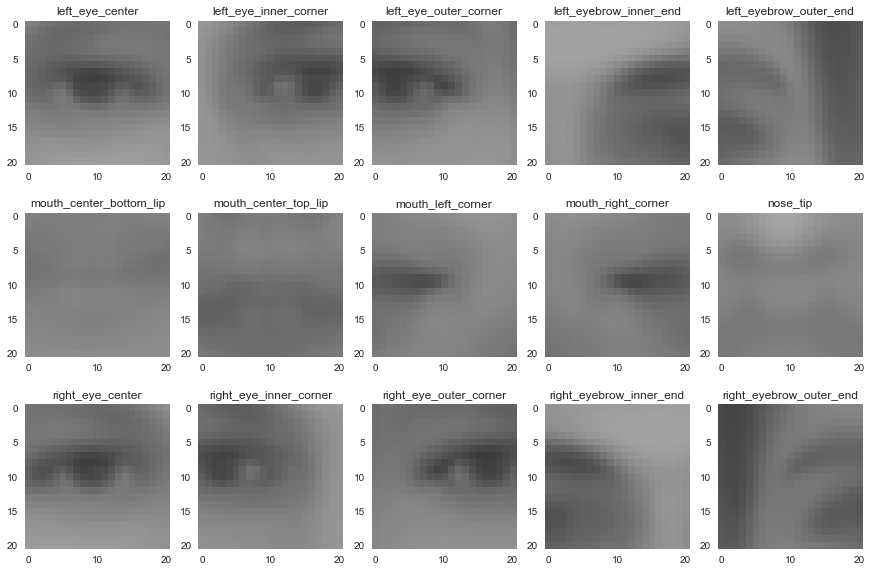

In [12]:
# show means of all keypoints
def display_keypoints_means(keypoint_patch_means, keypoints):
    fig = plt.figure(figsize=(15,10))
    for i, keypoint in enumerate(keypoints):
        ax = fig.add_subplot(3, 5, i+1)
        img = Image.fromarray(keypoint_patch_means[keypoint])
        ax.imshow(img)
        ax.grid(False)
        ax.set(title=keypoint)
display_keypoints_means(all_keypoints_patches_means_train, keypoints)

In [14]:
# note: it's currently assumed that searches will result in valid coords for all keypoints
search_size = 2

def find_image_all_keypoints_best_coord(image, keypoints, keypoint_coord_means, keypoint_patch_means, search_size, patch_size):
    patches = pd.Series(index=keypoints_expanded, dtype=object)
    for keypoint in keypoints:
        best_coords = find_keypoint_best_coord(image, keypoint, keypoint_coord_means[keypoint+'_x'], keypoint_coord_means[keypoint+'_y'], keypoint_patch_means[keypoint], search_size, patch_size)
        patches[keypoint + '_x'] = best_coords[0]
        patches[keypoint + '_y'] = best_coords[1]
    return patches

def find_keypoint_best_coord(image, keypoint, coord_means_x, coord_means_y, patch_means, search_size, patch_size):
    curr_best_coord_x = 0
    curr_best_coord_y = 0
    curr_best_corr = -math.inf
    for delta_x in range(-search_size, search_size+1):
        for delta_y in range(-search_size, search_size+1):
            x_left = int(round(coord_means_x + delta_x - patch_size))
            x_right = int(round(coord_means_x + delta_x + patch_size))
            y_top = int(round(coord_means_y + delta_y - patch_size))
            y_bottom = int(round(coord_means_y + delta_y + patch_size))
            
            patch_curr = image[y_top:y_bottom+1 , x_left:x_right+1]
            curr_patch_corr = np.corrcoef(patch_curr.flatten(), patch_means.flatten())[0][1]
            if curr_patch_corr > curr_best_corr:
                curr_best_corr = curr_patch_corr
                curr_best_coord_x = coord_means_x + delta_x
                curr_best_coord_y = coord_means_y + delta_y
    return (curr_best_coord_x , curr_best_coord_y)


validation_pred = validation['Image'].apply(find_image_all_keypoints_best_coord, keypoints=keypoints, keypoint_coord_means=keypoint_coord_means_train, keypoint_patch_means=all_keypoints_patches_means_train, search_size=search_size, patch_size=patch_size)


In [15]:
actual_validation_reshaped = []
pred_validation_reshaped = []
for idx in validation.index:
    curr_actual_validation_row = validation.drop(['Image'], axis=1, inplace=False, ).loc[idx, :]
    curr_pred_validation_row = validation_pred.loc[idx, :]
    for keypoint in curr_actual_validation_row.index:
        if not np.isnan(curr_actual_validation_row[keypoint]):
            actual_validation_reshaped.append(curr_actual_validation_row[keypoint])
            pred_validation_reshaped.append(curr_pred_validation_row[keypoint])

rmse_validation = math.sqrt(mean_squared_error(actual_validation_reshaped, pred_validation_reshaped))
print('rmse: {}'.format(rmse_validation))

rmse: 3.695002634432288


In [16]:
id_lookup_table = pd.read_csv('IdLookupTable.csv')
# id_lookup_table

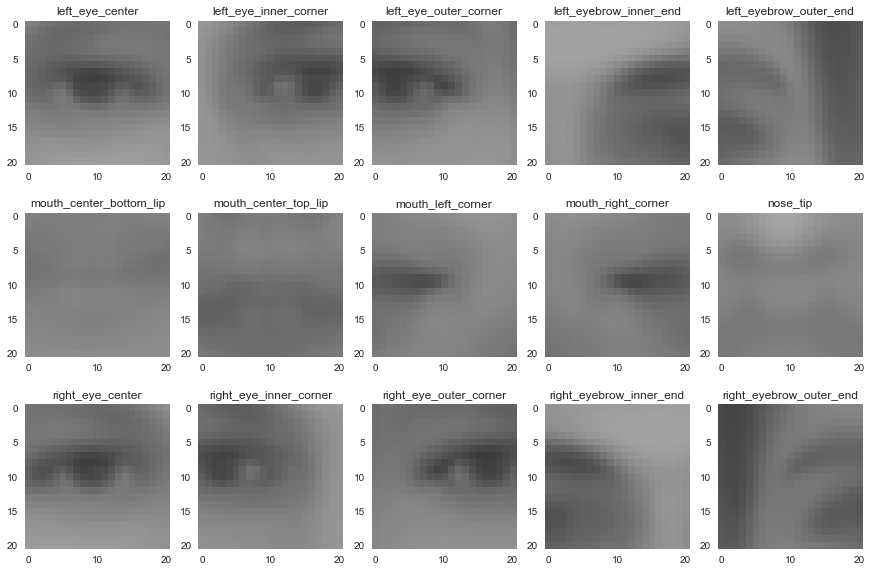

In [22]:
keypoint_coord_means_train_orig = round(train_orig.iloc[:, 0:30].mean(axis=0, skipna=True))
all_keypoints_patches_means_train_orig = find_all_keypoints_patches_means(train, keypoints, patch_size=10)
display_keypoints_means(all_keypoints_patches_means_train_orig, keypoints)
test_pred = test['Image'].apply(find_image_all_keypoints_best_coord, keypoints=keypoints, keypoint_coord_means=keypoint_coord_means_train_orig, keypoint_patch_means=all_keypoints_patches_means_train_orig, search_size=search_size, patch_size=patch_size)
test_pred['ImageId'] = test['ImageId']
test_pred.set_index('ImageId', drop=True, inplace=True)

In [52]:
def find_pred_given_id_row(row, test_pred):
    return test_pred.loc[row['ImageId'], row['FeatureName']]

test_results_for_submission = pd.DataFrame(id_lookup_table['RowId'], columns=['RowId'])
test_results_for_submission['Location'] = id_lookup_table.apply(find_pred_given_id_row, test_pred=test_pred, axis=1)

In [55]:
test_results_for_submission.to_csv('submission_patch_search_method.csv', index=False)